# Backbone atoms (allatom without side-chains)

Parameters:

* $c$ -- cutoff
* $b$ -- number of bins for each pair of atom types
* $r$ -- topological distance to skipping neighbouring atoms

In [1]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import seaborn
from multiprocessing import Pool, TimeoutError
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer, normalize, MaxAbsScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, LinearRegression,
                                  BayesianRidge, ElasticNet, Ridge)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from data_mining import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
mat_file_patterns = []

for sigma in [0, 0.01, 0.1, 1]:
    for num_bins in [15, 20, 25, 30, 35, 40, 45]:
        for cutoff in [5, 6, 6.5, 7, 7.5, 8]:
            for radius in [2]:
                mat_file_patterns.append(
                    '*backboneatoms-s{}-b{}-c{}-r{}--skip_errors.mat'.format(sigma, num_bins, cutoff, radius)
                )

In [3]:
checksums = ['8360e499006b09a5c2768cbbd2e09ecf']

In [4]:
def get_natives(scores):
    natives = np.array([bool(re.match('T0...\.pdb', x.split('/')[-1])) for x in scores.index])
    return pd.Series(data=natives, index=scores.index)

In [5]:
models = [
    ("Normalizer + Logistic",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', LogisticRegression(class_weight={False: 1, True: 100}))]),
     lambda lr_clf, X_train, scores_train: lr_clf.fit(X_train, get_natives(scores_train)),
     lambda lr_clf, X: -lr_clf.decision_function(X)),
    ("MaxAbsScaler + Logistic",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', LogisticRegression(class_weight={False: 1, True: 100}))]),
     lambda lr_clf, X_train, scores_train: lr_clf.fit(X_train, get_natives(scores_train)),
     lambda lr_clf, X: -lr_clf.decision_function(X)),
    ("Normalizer + Ridge",
     Pipeline([('normalizer', Normalizer()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(fit_intercept=False))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X)),
    ("MaxAbsScaler + Ridge",
     Pipeline([('normalizer', MaxAbsScaler()),
               ('one_hot_imputer', OneHotImputer()),
               ('model', Ridge(fit_intercept=False))]),
     lambda ridge_lm, X_train, scores_train: ridge_lm.fit(X_train, 1 - scores_train['GDT-TS-score']),
     lambda ridge_lm, X: ridge_lm.predict(X))
]

In [6]:
scores = load_pickled_dataset(dataset_binary_filename(mat_file_patterns[50], checksums[0], 'binaries'))[1]
scores = select_subset(scores, scores, '^.*CASP([5-9]|10)/T..../.*$')[1]
indices = scores.index.sort_values().copy()

In [7]:
results_train = {}
results_val = {}

In [8]:
def compute_results(args):
    try:
        mat_file_pattern, indices = args

        for checksum in checksums:
            try:
                X, scores, _ = load_pickled_dataset(
                    dataset_binary_filename(mat_file_pattern, checksum, 'binaries')
                )
                break
            except:
                X, scores = None, None

        if X is None:
            print(mat_file_pattern, '\tError: Dataset not found', flush=True)
            return mat_file_pattern, None

        scores['__temp_index'] = range(scores.shape[0])
        scores = scores.loc[indices]
        if pd.isnull(scores['__temp_index']).sum():
            print(mat_file_pattern, '\tError: Got smaller dataset', flush=True)
            return mat_file_pattern, None

        X = X[scores['__temp_index'].values]
        del scores['__temp_index']

        old_shape = X.shape
        X, nonzero_features = remove_zero_features(X)
        print(mat_file_pattern, '\tX.size: {},\t{} -> {}'.format(X.size, old_shape, X.shape), flush=True)

        train_blocks, train_idx, val_blocks, val_idx = train_test_split(one_hot_from_scores(scores),
                                                                        test_ratio=0.4, seed=17)
        X_train = X[train_idx]
        X_val = X[val_idx]
        del X
        scores_train = scores[train_idx]
        scores_val = scores[val_idx]

        results_train = {}
        results_val = {}

        for model_name, model, train, predicted_score in models:

            ### Train
            train(model, X_train, scores[train_idx])

            ### Results on training set
            results_train[model_name + ' + native'], _ = scoring_results(X_train, scores_train,
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)

            results_train[model_name], _ = scoring_results(X_train[~get_natives(scores_train).values],
                                                           scores_train[~get_natives(scores_train).values],
                                                           lambda X: predicted_score(model, X),
                                                           num_plots=0)
            ### Results on validation set
            results_val[model_name + ' + native'], _ = scoring_results(X_val, scores_val,
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

            results_val[model_name], _ = scoring_results(X_val[~get_natives(scores_val).values],
                                                         scores_val[~get_natives(scores_val).values],
                                                         lambda X: predicted_score(model, X),
                                                         num_plots=0)

        return mat_file_pattern, (results_train, results_val)
    except Exception as e:
        print(mat_file_pattern, '\tError: Exception', e, flush=True)
        return mat_file_pattern, None

In [11]:
pool = Pool(processes=15)
pool_result = pool.imap_unordered(compute_results, [(mat_file_pattern, indices)
                                       for mat_file_pattern in mat_file_patterns
                                       if mat_file_pattern not in results_train.keys()])
pool.close()

In [12]:
returned = []

try:
    while True:
        returned.append(pool_result.next(timeout=0))
except TimeoutError:
    print('Timeout')
except StopIteration:
    print('Done')

for mat_file_pattern, res in returned:
    if res:
        results_train[mat_file_pattern], results_val[mat_file_pattern] = res

len(returned), len([x for x in returned if x[1]])

Done


(0, 0)

## Test

In [13]:
params = ['s', 'b', 'c']

In [14]:
def mean_top1_score(scores):
    return scores['GDT-TS-score']['Mean score for top 1']

def correlation_score(scores):
    return -scores['GDT-TS-score'][['Mean Pearson', 'Mean Spearman']].mean()

def summary(results):
    records = []
    for quality_criterion in [mean_top1_score, correlation_score]:
        for model in sorted(list(results.items())[0][1].keys()):
            benchmark = generate_benchmark(results, quality_criterion)
            best_dataset = benchmark[model].argmax()
            records.append((best_dataset,
                            model + ' + ' + quality_criterion.__name__,
                            results[best_dataset][model]['GDT-TS-score']))
    df = pd.concat([x[2] for x in records], axis=1)
    df.columns = [x[1] for x in records]
    df.loc['The best dataset'] = [x[0] for x in records]
    return df

def plot_results(results, model, quality_criterion, params, **kwargs):
    benchmark = generate_benchmark(results, quality_criterion)
    plot_heatmaps(benchmark, model, params, **kwargs)

    print('The best:\n{}'.format(benchmark[model].argmax()))
    display(results[benchmark[model].argmax()][model])

In [15]:
df = summary(results_val)
display(df.iloc[:, [c.split(' + ')[-2] == 'native' for c in df.columns]].T)
display(df.iloc[:, [c.split(' + ')[-2] != 'native' for c in df.columns]].T)

Mean rank of the native  \
MaxAbsScaler + Logistic + native + mean_top1_score                 7.86726   
MaxAbsScaler + Ridge + native + mean_top1_score                    52.9956   
Normalizer + Logistic + native + mean_top1_score                   14.1549   
Normalizer + Ridge + native + mean_top1_score                      85.9867   
MaxAbsScaler + Logistic + native + correlation_...                 12.0531   
MaxAbsScaler + Ridge + native + correlation_score                  52.2434   
Normalizer + Logistic + native + correlation_score                 18.9336   
Normalizer + Ridge + native + correlation_score                    77.0664   

                                                        Top 1      Top 5  \
MaxAbsScaler + Logistic + native + mean_top1_score    0.49115   0.681416   
MaxAbsScaler + Ridge + native + mean_top1_score     0.0884956   0.221239   
Normalizer + Logistic + native + mean_top1_score     0.247788   0.526549   
Normalizer + Ridge + native + mean_top1_score        0.039823  0.0840708   
MaxAbsScaler + Logistic + native + correlation_...   0.318584   0.579646   
MaxAbsScaler + Ridge + native + correlation_score   0.0752212   0.247788   
Normalizer + Logistic + native + correlation_score    0.20354   0.389381   
Normalizer + Ridge + native + correlation_score     0.0221239  0.0840708   

                                                   Mean score for top 1  \
MaxAbsScaler + Logistic + native + mean_top1_score             0.756708   
MaxAbsScaler + Ridge + native + mean_top1_score                0.555888   
Normalizer + Logistic + native + mean_top1_score               0.584792   
Normalizer + Ridge + native + mean_top1_score                   0.49982   
MaxAbsScaler + Logistic + native + correlation_...             0.613978   
MaxAbsScaler + Ridge + native + correlation_score              0.536172   
Normalizer + Logistic + native + correlation_score             0.527177   
Normalizer + Ridge + native + correlation_score                0.447596   

                                                   Mean loss score  \
MaxAbsScaler + Logistic + native + mean_top1_score        0.243292   
MaxAbsScaler + Ridge + native + mean_top1_score           0.444112   
Normalizer + Logistic + native + mean_top1_score          0.415208   
Normalizer + Ridge + native + mean_top1_score              0.50018   
MaxAbsScaler + Logistic + native + correlation_...        0.386022   
MaxAbsScaler + Ridge + native + correlation_score         0.463828   
Normalizer + Logistic + native + correlation_score        0.472823   
Normalizer + Ridge + native + correlation_score           0.552404   

                                                   Mean Pearson Mean Spearman  \
MaxAbsScaler + Logistic + native + mean_top1_score   -0.0998383     -0.027872   
MaxAbsScaler + Ridge + native + mean_top1_score       -0.522469     -0.437535   
Normalizer + Logistic + native + mean_top1_score     -0.0979697    -0.0490156   
Normalizer + Ridge + native + mean_top1_score         -0.454075     -0.336397   
MaxAbsScaler + Logistic + native + correlation_...     -0.15229    -0.0955337   
MaxAbsScaler + Ridge + native + correlation_score     -0.533327     -0.446463   
Normalizer + Logistic + native + correlation_score    -0.188197      -0.13345   
Normalizer + Ridge + native + correlation_score       -0.480642     -0.356061   

                                                                                   The best dataset  
MaxAbsScaler + Logistic + native + mean_top1_score   *backboneatoms-s0.1-b45-c5-r2--skip_errors.mat  
MaxAbsScaler + Ridge + native + mean_top1_score        *backboneatoms-s1-b45-c8-r2--skip_errors.mat  
Normalizer + Logistic + native + mean_top1_score    *backboneatoms-s0.01-b35-c5-r2--skip_errors.mat  
Normalizer + Ridge + native + mean_top1_score       *backboneatoms-s0.01-b35-c5-r2--skip_errors.mat  
MaxAbsScaler + Logistic + native + correlation_...  *backboneatoms-s0.01-b15-c7-r2--skip_errors.mat  
MaxAbsScaler +

Mean rank of the native  \
MaxAbsScaler + Logistic + mean_top1_score                   122.695   
MaxAbsScaler + Ridge + mean_top1_score                      101.496   
Normalizer + Logistic + mean_top1_score                     114.903   
Normalizer + Ridge + mean_top1_score                        110.469   
MaxAbsScaler + Logistic + correlation_score                  116.19   
MaxAbsScaler + Ridge + correlation_score                    88.4867   
Normalizer + Logistic + correlation_score                   110.261   
Normalizer + Ridge + correlation_score                      103.792   

                                                  Top 1      Top 5  \
MaxAbsScaler + Logistic + mean_top1_score    0.00884956   0.039823   
MaxAbsScaler + Ridge + mean_top1_score        0.0132743  0.0442478   
Normalizer + Logistic + mean_top1_score       0.0132743   0.039823   
Normalizer + Ridge + mean_top1_score         0.00442478  0.0309735   
MaxAbsScaler + Logistic + correlation_score  0.00884956   0.039823   
MaxAbsScaler + Ridge + correlation_score     0.00884956  0.0619469   
Normalizer + Logistic + correlation_score    0.00442478   0.039823   
Normalizer + Ridge + correlation_score                0  0.0353982   

                                            Mean score for top 1  \
MaxAbsScaler + Logistic + mean_top1_score               0.466775   
MaxAbsScaler + Ridge + mean_top1_score                  0.508322   
Normalizer + Logistic + mean_top1_score                 0.437962   
Normalizer + Ridge + mean_top1_score                    0.467392   
MaxAbsScaler + Logistic + correlation_score             0.433137   
MaxAbsScaler + Ridge + correlation_score                0.483195   
Normalizer + Logistic + correlation_score               0.412064   
Normalizer + Ridge + correlation_score                  0.431084   

                                            Mean loss score Mean Pearson  \
MaxAbsScaler + Logistic + mean_top1_score          0.173402   -0.0824845   
MaxAbsScaler + Ridge + mean_top1_score             0.131855    -0.508625   
Normalizer + Logistic + mean_top1_score            0.202215    -0.130796   
Normalizer + Ridge + mean_top1_score               0.172785    -0.449752   
MaxAbsScaler + Logistic + correlation_score         0.20704    -0.126369   
MaxAbsScaler + Ridge + correlation_score           0.156982    -0.531867   
Normalizer + Logistic + correlation_score          0.228113    -0.167253   
Normalizer + Ridge + correlation_score             0.209093    -0.487468   

                                            Mean Spearman  \
MaxAbsScaler + Logistic + mean_top1_score      -0.0404971   
MaxAbsScaler + Ridge + mean_top1_score          -0.418486   
Normalizer + Logistic + mean_top1_score        -0.0988503   
Normalizer + Ridge + mean_top1_score             -0.33196   
MaxAbsScaler + Logistic + correlation_score     -0.086754   
MaxAbsScaler + Ridge + correlation_score        -0.443608   
Normalizer + Logistic + correlation_score       -0.125487   
Normalizer + Ridge + correlation_score          -0.354054   

                                                                              The best dataset  
MaxAbsScaler + Logistic + mean_top1_score      *backboneatoms-s0.01-b15-c5-r2--skip_errors.mat  
MaxAbsScaler + Ridge + mean_top1_score          *backboneatoms-s0.1-b45-c5-r2--skip_errors.mat  
Normalizer + Logistic + mean_top1_score      *backboneatoms-s0.01-b15-c7.5-r2--skip_errors.mat  
Normalizer + Ridge + mean_top1_score           *backboneatoms-s0.01-b30-c5-r2--skip_errors.mat  
MaxAbsScaler + Logistic + correlation_score    *backboneatoms-s0.01-b15-c7-r2--skip_errors.mat  
MaxAbsScaler + Ridge + correlation_score          *backboneatoms-s0-b30-c7-r2--skip_errors.mat  
Normalizer + Logistic + correlation_score         *backboneatoms-s1-b15-c8-r2--skip_errors.mat  
Normalizer + Ridge + correlation_score            *backboneatoms-s0-b45-c7-r2--skip_errors.mat

### Classification

#### Row normalization

##### Mean score for top 1

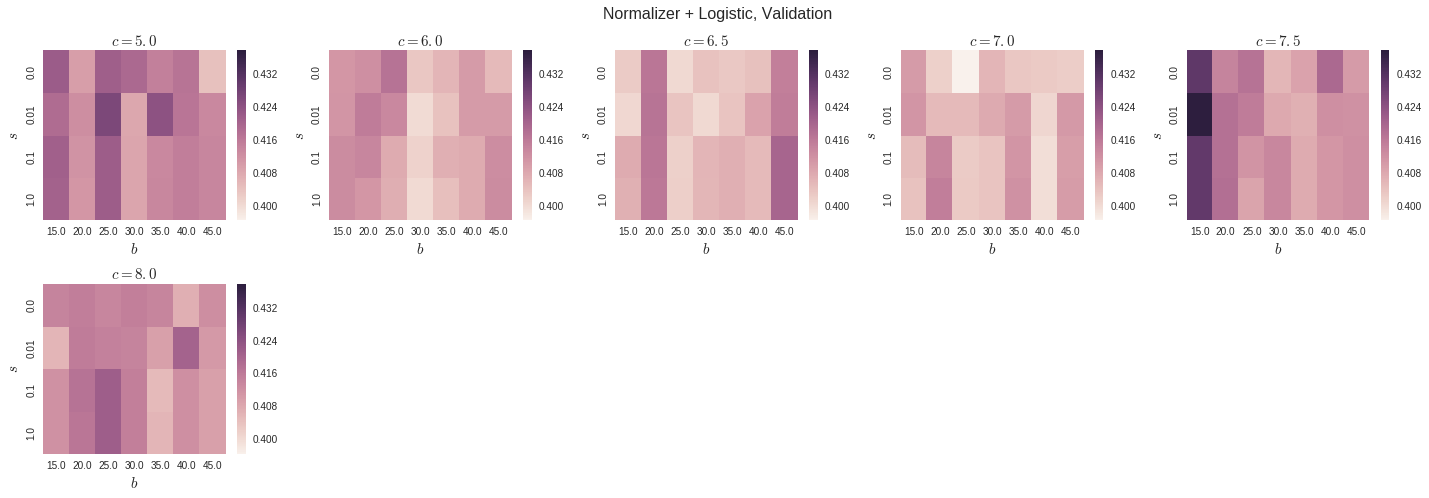

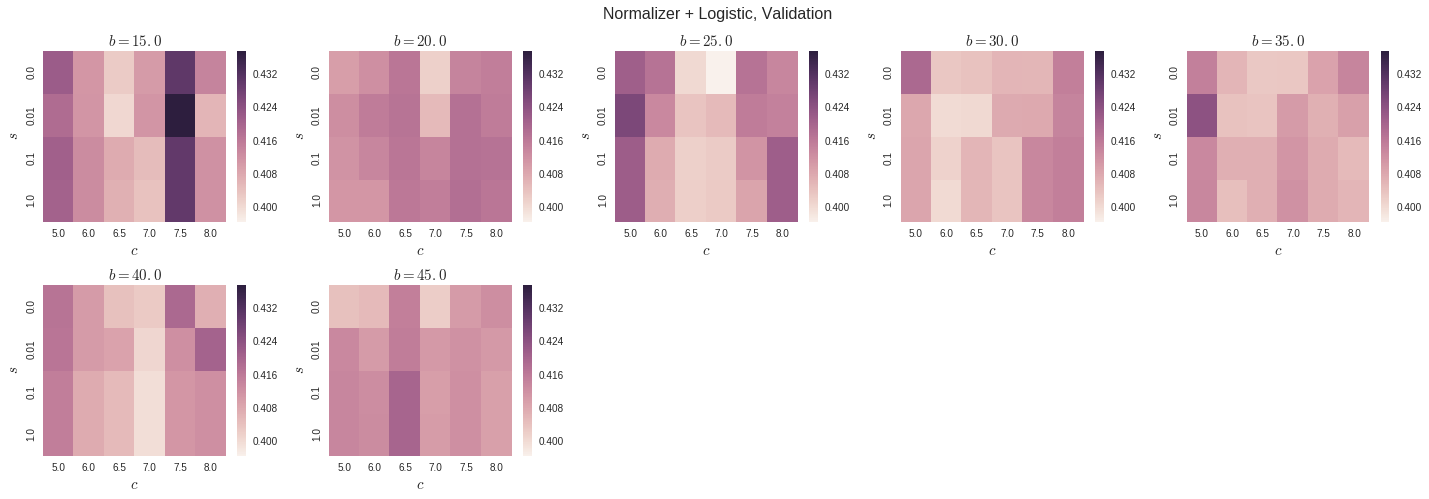

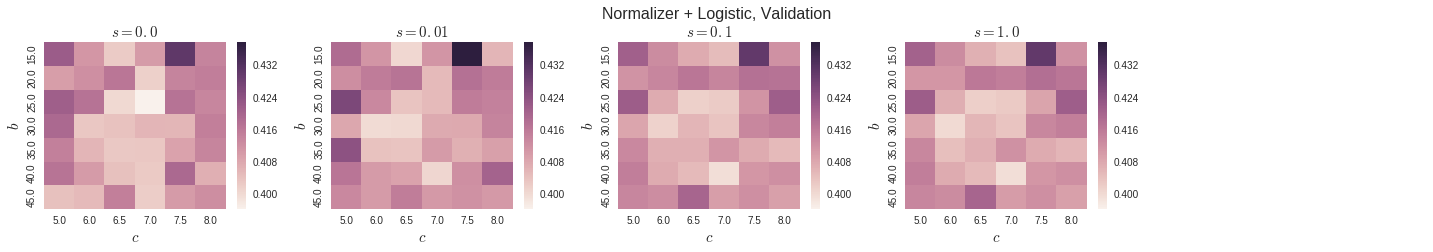

The best:
*backboneatoms-s0.01-b15-c7.5-r2--skip_errors.mat


RMSD    TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native     95.323     123.876      113.531      114.903   
Top 1                    0.0309735  0.00884956    0.0132743    0.0132743   
Top 5                     0.106195   0.0353982     0.039823     0.039823   
Mean score for top 1       8.71189    0.494201     0.403641     0.437962   
Mean loss score           -6.08529    0.218404     0.205648     0.202215   
Mean Pearson              0.209661    -0.11003    -0.137697    -0.130796   
Mean Spearman             0.190835  -0.0654155    -0.110665   -0.0988503   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      111.637        218.381             79.177   
Top 1                      0.0176991     0.00442478          0.0486726   
Top 5                      0.0442478     0.00884956           0.163717   
Mean score for top 1         0.31594        8.71189           0.553696   
Mean loss score             0.160482        55.1232           0.200612   
Mean Pearson               -0.152866       0.209661          -0.196837   
Mean Spearman              -0.133446       0.190813          -0.199319   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                81.6681                79.6195   
Top 1                                0.0442478              0.0353982   
Top 5                                 0.123894               0.137168   
Mean score for top 1                  0.469388               0.512914   
Mean loss score                       0.263419               0.245935   
Mean Pearson                         -0.211302              -0.219418   
Mean Spearman                        -0.222738              -0.233701   

                        GDT-HA-score-backwards  
Mean rank of the native                82.8097  
Top 1                                0.0486726  
Top 5                                 0.128319  
Mean score for top 1                  0.370951  
Mean loss score                       0.232403  
Mean Pearson                         -0.226094  
Mean Spearman                        -0.240462

In [16]:
plot_results(results_val,
             'Normalizer + Logistic', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1)

##### Correlation score

plot_results(results_val,
             'Normalizer + Logistic', correlation_score,
             params, info='Validation', num_cols=4, figsize=1.2)

#### Feature normalization

##### Mean score for top 1

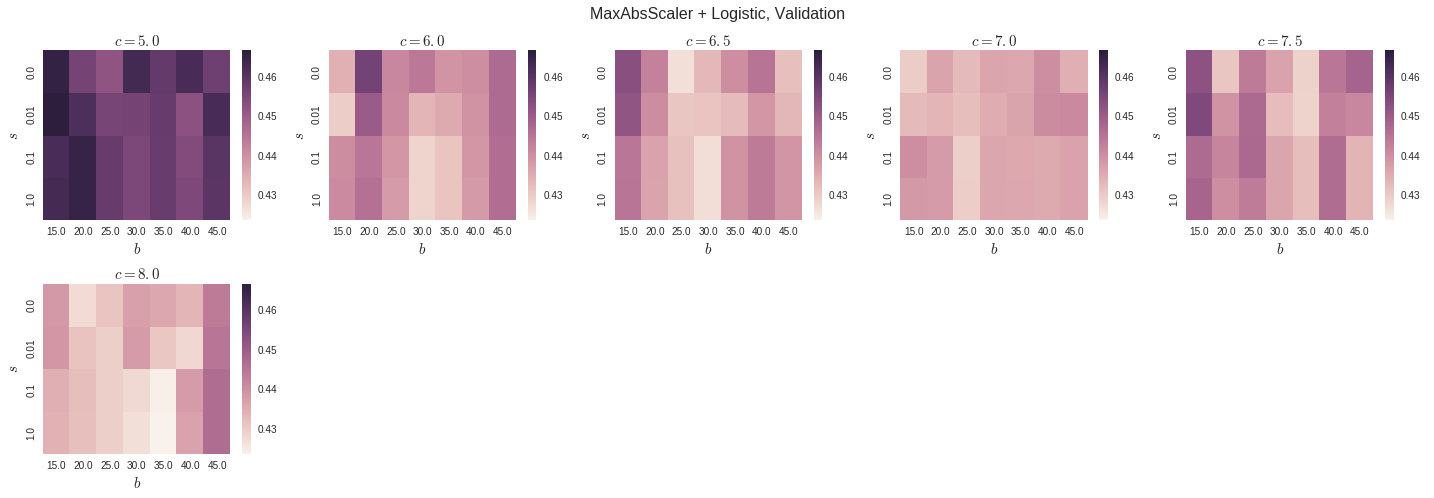

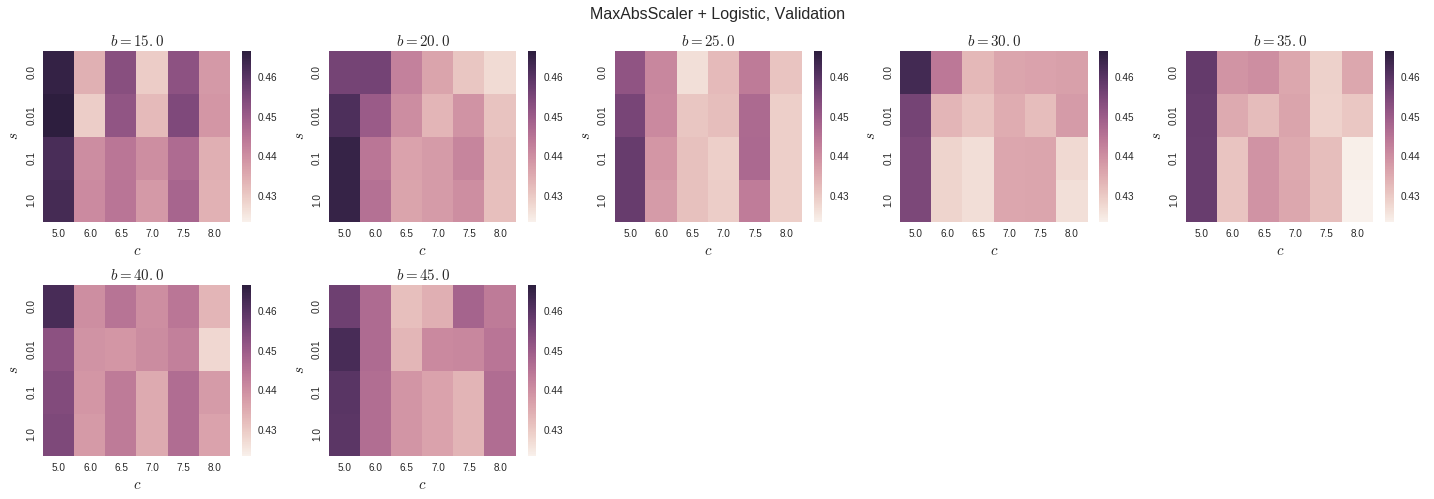

The best:
*backboneatoms-s0.01-b15-c5-r2--skip_errors.mat


RMSD     TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native    87.1327      130.323      122.394      122.695   
Top 1                            0    0.0176991    0.0132743   0.00884956   
Top 5                    0.0176991     0.039823    0.0575221     0.039823   
Mean score for top 1       10.3718     0.537115     0.425732     0.466775   
Mean loss score           -7.74521      0.17549     0.183556     0.173402   
Mean Pearson               0.13815   -0.0541024   -0.0949611   -0.0824845   
Mean Spearman             0.159459  0.000540525   -0.0593901   -0.0404971   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      119.597        186.991            80.0354   
Top 1                      0.0132743              0                  0   
Top 5                      0.0442478     0.00442478          0.0353982   
Mean score for top 1        0.332168        10.3718           0.524985   
Mean loss score             0.144254        53.4633           0.229324   
Mean Pearson               -0.111167        0.13815          -0.151109   
Mean Spearman              -0.083813       0.159451          -0.158241   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                73.3009                72.8761   
Top 1                                        0                      0   
Top 5                                0.0265487              0.0176991   
Mean score for top 1                  0.412966                0.45284   
Mean loss score                       0.319841                0.30601   
Mean Pearson                         -0.187623              -0.193752   
Mean Spearman                        -0.205002              -0.213512   

                        GDT-HA-score-backwards  
Mean rank of the native                74.3805  
Top 1                               0.00442478  
Top 5                                0.0221239  
Mean score for top 1                  0.321847  
Mean loss score                       0.281507  
Mean Pearson                          -0.20611  
Mean Spearman                        -0.226672

In [17]:
plot_results(results_val,
             'MaxAbsScaler + Logistic', mean_top1_score,
             params, info='Validation', num_cols=5, figsize=1)

##### Correlation score

plot_results(results_val,
             'MaxAbsScaler + Logistic', correlation_score,
             params, info='Validation', num_cols=4, figsize=1.2)

### Regression

#### Row normalization

##### Mean score for top 1

plot_results(results_val,
             'Normalizer + Ridge', mean_top1_score,
             params, info='Validation', num_cols=4, figsize=1.2)

##### Correlation score

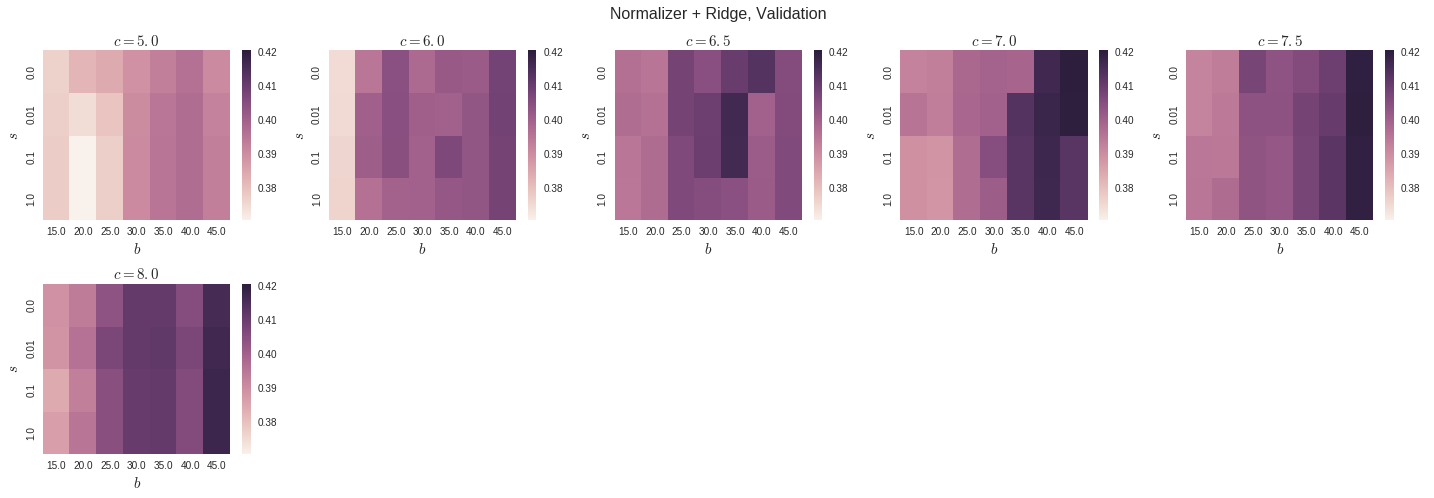

The best:
*backboneatoms-s0-b45-c7-r2--skip_errors.mat


RMSD   TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native    123.142    108.903      104.119      103.792   
Top 1                    0.0176991          0            0            0   
Top 5                    0.0619469  0.0221239    0.0265487    0.0353982   
Mean score for top 1       9.63868   0.493477     0.396559     0.431084   
Mean loss score           -7.01208   0.219128      0.21273     0.209093   
Mean Pearson              0.409613  -0.487299    -0.470076    -0.487468   
Mean Spearman             0.317691  -0.342432    -0.339555    -0.354054   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      98.6372        236.841            89.7743   
Top 1                     0.00442478     0.00442478         0.00884956   
Top 5                      0.0442478     0.00442478          0.0530973   
Mean score for top 1        0.306602        9.63868           0.515883   
Mean loss score              0.16982        54.1964           0.238426   
Mean Pearson               -0.484442       0.409613          -0.493995   
Mean Spearman              -0.363298       0.317721          -0.382459   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                113.796                113.478   
Top 1                               0.00884956              0.0132743   
Top 5                                0.0486726              0.0575221   
Mean score for top 1                  0.423141               0.462524   
Mean loss score                       0.309665               0.296325   
Mean Pearson                         -0.439637               -0.45348   
Mean Spearman                        -0.352333               -0.36966   

                        GDT-HA-score-backwards  
Mean rank of the native                111.938  
Top 1                                0.0132743  
Top 5                                0.0486726  
Mean score for top 1                  0.328444  
Mean loss score                        0.27491  
Mean Pearson                         -0.435856  
Mean Spearman                        -0.366191

In [18]:
plot_results(results_val,
             'Normalizer + Ridge', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

#### Feature normalization

##### Mean score for top 1

plot_results(results_val,
             'MaxAbsScaler + Ridge', mean_top1_score,
             params, info='Validation', num_cols=4, figsize=1.2)

##### Correlation score

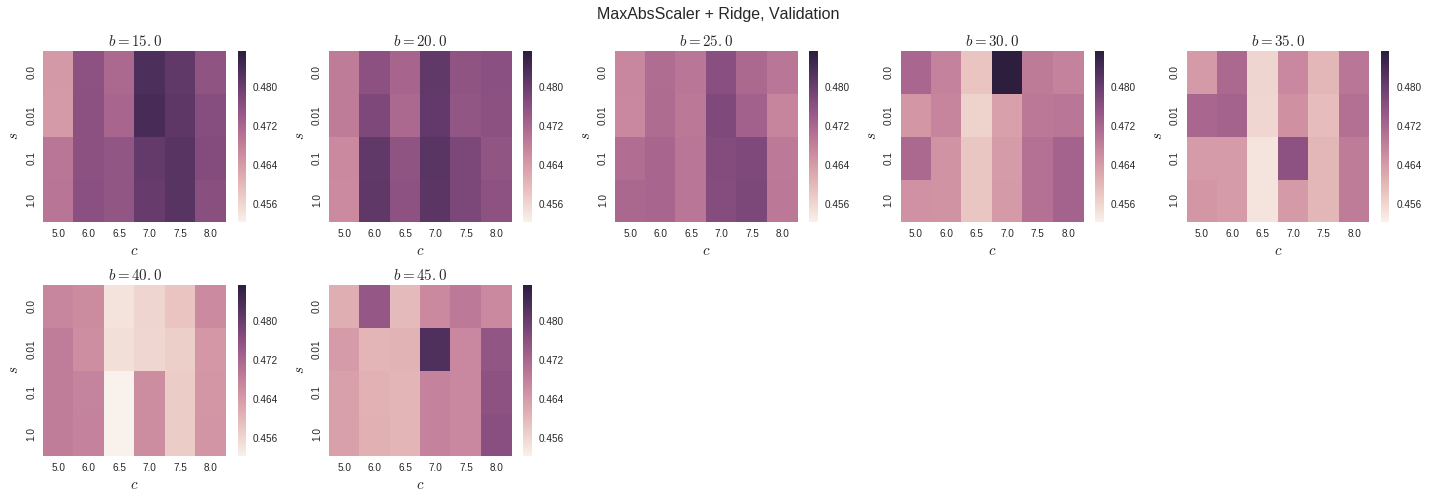

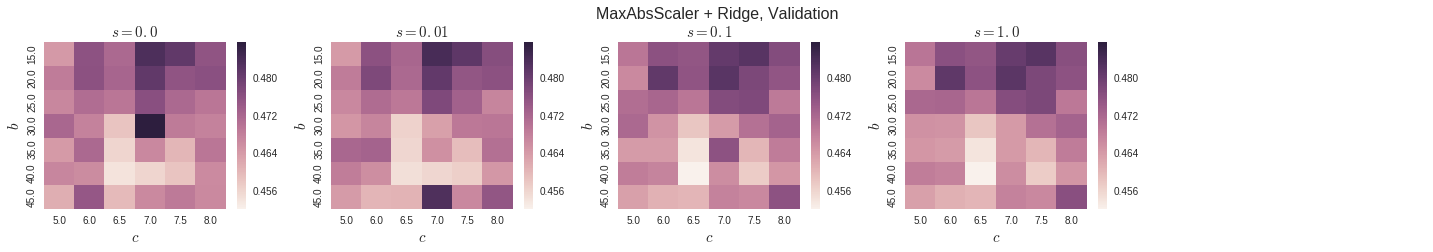

The best:
*backboneatoms-s0-b30-c7-r2--skip_errors.mat


RMSD   TM-score MaxSub-score GDT-TS-score  \
Mean rank of the native     142.358    91.4469       88.531      88.4867   
Top 1                    0.00442478  0.0221239   0.00884956   0.00884956   
Top 5                     0.0265487  0.0707965    0.0663717    0.0619469   
Mean score for top 1        9.97742   0.554125     0.444329     0.483195   
Mean loss score            -7.35082    0.15848      0.16496     0.156982   
Mean Pearson                0.40411  -0.528599    -0.518387    -0.531867   
Mean Spearman              0.315951  -0.438058     -0.42591    -0.443608   

                        GDT-HA-score RMSD-backwards TM-score-backwards  \
Mean rank of the native      86.3982        233.159            116.004   
Top 1                     0.00884956              0         0.00884956   
Top 5                      0.0619469     0.00442478          0.0176991   
Mean score for top 1        0.345276        9.97742           0.531251   
Mean loss score             0.131147        53.8577           0.223058   
Mean Pearson                -0.53308        0.40411          -0.502563   
Mean Spearman              -0.445407       0.315954          -0.394882   

                        MaxSub-score-backwards GDT-TS-score-backwards  \
Mean rank of the native                 139.77                138.527   
Top 1                               0.00442478             0.00442478   
Top 5                                0.0176991              0.0176991   
Mean score for top 1                  0.421479               0.457858   
Mean loss score                       0.311327               0.300991   
Mean Pearson                         -0.461735               -0.47119   
Mean Spearman                        -0.368787              -0.377084   

                        GDT-HA-score-backwards  
Mean rank of the native                136.491  
Top 1                               0.00442478  
Top 5                                0.0221239  
Mean score for top 1                  0.327176  
Mean loss score                       0.276178  
Mean Pearson                         -0.458949  
Mean Spearman                        -0.381453

In [19]:
plot_results(results_val,
             'MaxAbsScaler + Ridge', correlation_score,
             params, info='Validation', num_cols=5, figsize=1)

## Backup

In [9]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

### Save dump

In [20]:
if len(results_train) == 0:
    raise Exception('Empty results')
joblib.dump((results_train, results_val), theNotebook + '.pkl')

['benchmark_backboneatoms.pkl']

### Load from dump

In [10]:
results_train, results_val = joblib.load(theNotebook + '.pkl')